In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import torch.nn.init as init
import math
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal_(m.weight, mode = 'fan_out')
            if m.bias is not None:
                init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant_(m.weight, 1)
            init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal_(m.weight, std=1e-3)
            if m.bias is not None:
                init.constant_(m.bias, 0)

def norm(dim):
    return nn.GroupNorm(min(32, dim), dim)

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1: ])).item()
        return x.view(-1, shape)

class ConcatConv2d(nn.Module):

    def __init__(self, dim_in, dim_out, ksize = 3, stride = 1, padding = 0, dilation = 1, groups = 1, bias = True, transpose = False):
        super(ConcatConv2d, self).__init__()
        module = nn.ConvTranspose2d if transpose else nn.Conv2d
        self._layer = module(
            dim_in + 1, dim_out, kernel_size = ksize, stride = stride, padding = padding, dilation = dilation, groups = groups,
            bias = bias
        )

    def forward(self, t, x):
        tt = torch.ones_like(x[:, :1, :, :]) * t
        ttx = torch.cat([tt, x], 1)
        return self._layer(ttx)


class Drift(nn.Module):
    def __init__(self, dim):
        super(Drift, self).__init__()
        self.norm1 = norm(dim)
        self.relu = nn.ReLU(inplace = True)
        self.conv1 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm2 = norm(dim)
        self.conv2 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm3 = norm(dim)
    
    def forward(self, t, x):
        out = self.norm1(x)
        out = self.relu(out)
        out = self.conv1(t, out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(t, out)
        out = self.norm3(out)
        return out

class Diffusion(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(Diffusion, self).__init__()
        self.norm1 = norm(dim_in)
        self.relu = nn.ReLU(inplace = True)
        self.conv1 = ConcatConv2d(dim_in, dim_out, 3, 1, 1)
        self.norm2 = norm(dim_in)
        self.conv2 = ConcatConv2d(dim_in, dim_out, 3, 1, 1)
        self.fc = nn.Sequential(norm(dim_out), nn.ReLU(inplace = True), nn.AdaptiveAvgPool2d((1, 1)), Flatten(), nn.Linear(dim_out, 1), nn.Sigmoid())
    def forward(self, t, x):
        out = self.norm1(x)
        out = self.relu(out)
        out = self.conv1(t, out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(t, out)
        out = self.fc(out)
        return out

class SDENet(nn.Module):
    def __init__(self, layer_depth, num_classes = 10, dim = 64):
        super(SDENet, self).__init__()
        self.layer_depth = layer_depth 
        self.downsampling_layers = nn.Sequential(
            nn.Conv2d(1, dim, 3, 1),
            norm(dim),
            nn.ReLU(inplace = True),
            nn.Conv2d(dim, dim, 4, 2),
            norm(dim),
            nn.ReLU(inplace = True),
            nn.Conv2d(dim, dim, 4, 2)
        )
        self.drift = Drift(dim)
        self.diffusion = Diffusion(dim, dim)
        self.fc_layers = nn.Sequential(
            norm(dim),
            nn.ReLU(inplace = True),
            nn.AdaptiveAvgPool2d((1, 1)), Flatten(), nn.Linear(dim, 10)
        )
        self.deltat = 6./self.layer_depth
        self.apply(init_params)
        self.sigma = 500
    
    def forward(self, x, training_diffusion = False):
        out = self.downsampling_layers(x)
        if not training_diffusion:
            t = 0
            diffusion_term = self.sigma * self.diffusion(t, out)
            diffusion_term = torch.unsqueeze(diffusion_term, 2)
            diffusion_term = torch.unsqueeze(diffusion_term, 3)
            for i in range(self.layer_depth):
                t = 6 * (float(i))/self.layer_depth
                out = out + self.drift(t, out) * self.deltat + diffusion_term * math.sqrt(self.deltat) * torch.randn_like(out).to(x)
            final_out = self.fc_layers(out)
        else:
            t = 0
            final_out = self.diffusion(t, out.detach())
        return final_out

def test():
    model = SDENet(layer_depth = 10, num_classes = 10, dim = 64)
    return model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) 

if __name__ == '__main__':
    model = test()
    num_params = count_parameters(model)

In [2]:
def getMNIST(batch_size, test_batch_size, img_size, **kwargs):
    num_workers = kwargs.setdefault('num_workers', 1)
    kwargs.pop('input_size', None)
    print("Building MNIST data loader with {} workers".format(num_workers))

    transform_train = transforms.Compose([
            transforms.ToTensor(),
        ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])
    ds = []
    train_loader = DataLoader(
        datasets.MNIST(root='../data/mnist', train=True, download=True, transform=transform_train), batch_size=batch_size,
        shuffle=True, num_workers=num_workers, drop_last=True
    )
    ds.append(train_loader)

    test_loader = DataLoader(
        datasets.MNIST(root='../data/mnist', train=False, download=True, transform=transform_test),
        batch_size=test_batch_size, shuffle=False, num_workers=num_workers, drop_last=True
    )
    ds.append(test_loader)

    return ds


def getDataSet(data_type, batch_size, test_batch_size, imageSize):
    if data_type == 'svhn':
        train_loader, test_loader = getSVHN(batch_size, test_batch_size, imageSize)
    elif data_type == 'mnist':
        train_loader, test_loader = getMNIST(batch_size, test_batch_size, imageSize)
    elif data_type == 'semeion':
        train_loader, test_loader = getSEMEION(batch_size, test_batch_size, imageSize)
    return train_loader, test_loader

train_loader, test_loader = getDataSet('mnist', batch_size = 128, test_batch_size = 125, imageSize = 64)


Building MNIST data loader with 1 workers


9913344it [00:03, 2867665.71it/s]                             


Extracting ../data/mnist\MNIST\raw\train-images-idx3-ubyte.gz to ../data/mnist\MNIST\raw



29696it [00:00, 4898495.76it/s]          


Extracting ../data/mnist\MNIST\raw\train-labels-idx1-ubyte.gz to ../data/mnist\MNIST\raw



1649664it [00:00, 1751751.47it/s]                             


Extracting ../data/mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data/mnist\MNIST\raw



5120it [00:00, 2476627.43it/s]          

Extracting ../data/mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data/mnist\MNIST\raw



In [6]:
import torch.optim as optim
import argparse

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

print('load in-domain data: ', 'mnist')
train_loader_inDomain, test_loader_inDomain = getDataSet('mnist', 128, 128, 28)

net = SDENet(layer_depth = 6, num_classes = 10, dim = 64)
net = net.to(device)

real_label = 0
fake_label = 1

criterion = nn.CrossEntropyLoss()
criterion2 = nn.BCELoss()

optimizer_F = optim.SGD([ {'params': net.downsampling_layers.parameters()}, {'params': net.drift.parameters()},
{'params': net.fc_layers.parameters()}], lr = 0.1, momentum=0.9, weight_decay=5e-4)

optimizer_G = optim.SGD([ {'params': net.diffusion.parameters()}], lr = 0.1, momentum=0.9, weight_decay=5e-4)
net.sigma = 20

load in-domain data:  mnist
Building MNIST data loader with 1 workers


In [7]:
from torch.utils.tensorboard import SummaryWriter
writer_train = SummaryWriter('runs/sdenet/train')
writer_test = SummaryWriter('runs/sdenet/test')

In [10]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()

    train_loss = 0
    correct = 0
    total = 0
    train_loss_out = 0
    train_loss_in = 0

    ##training with in-domain data
    for batch_idx, (inputs, targets) in enumerate(train_loader_inDomain):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer_F.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss = loss.to(torch.float32)
        loss.backward()
        optimizer_F.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    #training with out-of-domain data
        label = torch.full((128, 1), real_label, device=device)
        optimizer_G.zero_grad()
        predict_in = net(inputs, training_diffusion = True)
        predict_in = predict_in.to(torch.float32)
        label = label.to(torch.float32)
        loss_in = criterion2(predict_in, label)
        loss_in.backward()
        label.fill_(fake_label)
        inputs_out = 2*torch.randn(128, 1, 28, 28, device = device) + inputs
        predict_out = net(inputs_out, training_diffusion=True)
        loss_out = criterion2(predict_out, label)
        loss_out.backward()
        train_loss_out += loss_out.item()
        train_loss_in += loss_in.item()
        optimizer_G.step()

        writer_train.add_scalar(loss_out, epoch)

    print('Train epoch:{} \tLoss: {:.6f} | Loss_in: {:.6f}, Loss_out: {:.6f} | Acc: {:.6f} ({}/{})'
        .format(epoch, train_loss/(len(train_loader_inDomain)), train_loss_in/len(train_loader_inDomain), train_loss_out/len(train_loader_inDomain), 100.*correct/total, correct, total))


def test(epoch):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader_inDomain):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = 0
            for j in range(5):
                current_batch = net(inputs)
                outputs = outputs + F.softmax(current_batch, dim = 1)

            outputs = outputs/5
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        print('Test epoch: {} | Acc: {:.6f} ({}/{})'
        .format(epoch, 100.*correct/total, correct, total))

In [3]:
import torch
import torch.nn as nn
import math

class Drift(nn.Module):
    def __init__(self):
        super(Drift, self).__init__()
        self.fc = nn.Linear(256, 256)
        self.relu = nn.ReLU(inplace = True)

    def forward(self, t, x):
        return self.relu(self.fc(x))

class Diffusion(nn.Module):
    def __init__(self):
        super(Diffusion, self).__init__()
        self.relu = nn.ReLU(inplace = True)
        self.fc1 = nn.Linear(50, 256)
        self.fc2 = nn.Linear(256, 1)
    
    def forward(self, t, x):            # (256, 050)
        out = self.relu(self.fc1(x))    # (256, 256)
        out = self.fc2(out)             # (256, 001)
        out = torch.sigmoid(out)        # (256, 001)
        return out

class SDENet(nn.Module):
    def __init__(self, layer_depth = 6):
        super(SDENet, self).__init__()
        self.layer_depth = layer_depth
        self.downsampling_layers = nn.Linear(256, 50)
        self.fc_layers = nn.Sequential(
            nn.ReLU(inplace = True),
            nn.Linear(50, 2))

        self.drift = Drift()
        self.diffusion = Diffusion()
        self.deltat = 4.0 / self.layer_depth
        self.sigma = 0.5

    def forward(self, x, training_diffusion = False):
        out = self.downsampling_layers(x)                   
        if not training_diffusion:
            t = 0
            diffusion_term = self.sigma * self.diffusion(t, out)
            
            for i in range(self.layer_depth):
                t = 4 * (float(i)) / self.layer_depth
                out = out * self.deltat + diffusion_term * math.sqrt(self.deltat) * torch.randn_like(out).to(x)

            final_out = self.fc_layers(out)
            mean = final_out[:, 0]
            sigma = F.softplus(final_out[:]) + 1e-3
            return mean, sigma
        else:
            t = 0 
            final_out = self.diffusion(t, out.detach())
            return final_out

In [6]:
import torch
torch.cuda.empty_cache()

import os
os.chdir('C:/Users/Renan/Desktop/dsai-thesis')
import torchvision.transforms as transforms 

from uncertainty.utils import image_size, image_loader, view_image
from data_loader import load_split_data

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_loader = load_split_data('train')

transform = transforms.Compose([
    transforms.Normalize(
        mean=[0.485],
        std =[0.229],
    ),
])

t1w, t2w = image_loader(train_loader, 2)
t1w, t2w = image_size(t1w, 1), image_size(t2w, 2)
t1w, t2w = transform(t1w), transform(t2w)

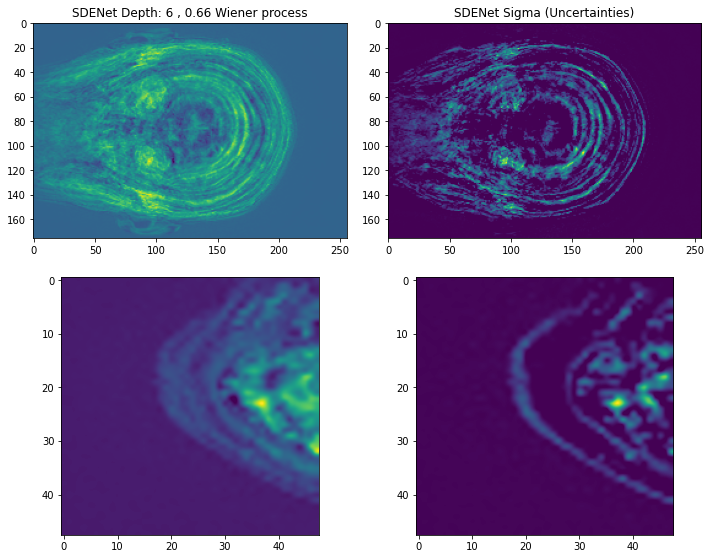

In [9]:
model = SDENet(6)

mean, sigma = model(t1w)
mean2, sigma2 = model(t2w)

import matplotlib.pyplot as plt

ave, sig = mean.detach().numpy(), sigma.detach().numpy() 
ave2, sig2 = mean2.detach().numpy(), sigma2.detach().numpy() 

fig = plt.figure(figsize = (10, 8))
ax1 = fig.add_subplot(221)
ax1.imshow(ave[:, :, 0] + ave[:, :, 1])
ax1.set_title('SDENet Depth: 6 , 0.66 Wiener process')
ax2 = fig.add_subplot(222)
ax2.imshow(sig[:, 0, :, 0])
ax2.set_title('SDENet Sigma (Uncertainties)')
ax3 = fig.add_subplot(223)
ax3.imshow(ave2[:, :48, 0] + ave2[:, :48, 1], interpolation = 'spline16')
ax4 = fig.add_subplot(224)
ax4.imshow(sig2[:, 0, :48, 0], interpolation = 'spline16')

plt.tight_layout()
plt.show()